In [1]:
%matplotlib inline



import pandas as pd
import requests
import re
import ast
import numpy as np
import seaborn as sns

from collections import defaultdict


In [2]:
ccc_df = pd.read_csv("data/ccc_blm.csv")
ele_df = pd.read_csv("data/ele.csv")
cl_df = pd.read_csv("data/cl_blm.csv")

dfs = [ccc_df, ele_df, cl_df]

In [3]:
df = pd.concat(dfs).reset_index(drop=True)
len(df)

4059

In [4]:
# fix stay commas

df['city_st'] = df['city_st'].str.replace(' , ', ', ')
df['city_st'] = df['city_st'].str.strip()


len(df)

4059

In [5]:
# eliminate non US events

countries = [
    "Finland",
    "England",
    "Wales",
    "Canada",
    "Scotland",
    "Germany",
    "Ireland", 'Sweden'
    "Netherlands",
    "New Zealand",
    "Denmark",
    "Australia",
    "Belgium",
    "France", 'Hungary',
]


def in_us(city_st):
    for c in countries:
        c2 = ", " + c
        if c2 in city_st:
            return False

    return True


df = df[df["city_st"].apply(in_us)].copy()
len(df)

4010

In [6]:
errors = {'Albuqeurque, NM' : 'Albuquerque, NM',
         'Bilings, MT' : 'Billings, MT',
         'Breckinridge, CO' : 'Breckinridge, CO',
          "Longbranch, NJ" : "Long Branch, NJ",
          'Lousiville, KY' : 'Louisville, KY',
          'Merrick, New York' : 'Merrick, NY',
          'Pittsfield Charter Township, MI' : 'Pittsfield, MI',
          'Pittsfield Township, MI' : 'Pittsfield, MI',
          'Phillipsburg, PA' : 'Philipsburg, PA',
          'South Sacramento, CA' :  'Sacramento, CA',
          'Shelbourne Falls, MA' : 'Shelburne Falls, MA',
          'Tallahasee, FL' : 'Tallahassee, FL',
          'Tampa Bay, FL' : "Tampa, Fl",
          'Voorhees Township, NJ' : 'Voorhees, NJ',
          'Warren Township, NJ' : 'Warren, NJ', 
          'Summerlin, NV' : 'Las Vegas, NV',
          'Stockton, TX' : 'Fort Stockton, TX',
          'Standford, CA' : 'Stanford, CA',
        
          
         }

for city in errors:
    df['city_st'] = df['city_st'].str.replace(city, errors[city])

In [7]:
#uniform saint to st
df['city_st'] = df['city_st'].str.replace('Saint ', 'St. ')

In [8]:
df['urls'] == "['https://kfor.com/news/local/protester-hit-by-vehicle-during-protest-in-tulsa-over-george-floyds-death/']'"

0       False
1       False
2       False
3       False
4       False
        ...  
4054    False
4055    False
4056    False
4057    False
4058    False
Name: urls, Length: 4010, dtype: bool

In [9]:
df['events'] = 1
df['size'] = df['size'].replace(0,np.nan)
df['size_imp'] = df['size'].fillna(11)


df = pd.concat([df, pd.get_dummies(df['collection'])], axis=1)

In [10]:
# extract urls to make them variables

def str_2_list(links):
    return ast.literal_eval(links)

df['url_list'] = df['urls'].apply(str_2_list)


urls = set([item for sublist in df['url_list'].values for item in sublist])

for url in urls:
    df[url] = df['urls'].str.contains(url)

First Pass at Aggregation

In [11]:
# first sum by collection for multiple events by city
df_cd = df.groupby(['collection', 'date', 'city_st']).sum().reset_index()

In [12]:
df_cd['size_imp'] = df_cd['size'].fillna(11)



In [13]:
for v in ["CCC", 
    "Count Love", 
    "Elephrame"]:
    df_cd[v] = df_cd[v] > 0
    df_cd[v] = df_cd[v].astype(int)

In [14]:

aggregation = {
    "events": "max",
    "size": "max",
    "size_imp" : "max",
    "CCC" : "max",
    "Count Love" : "max",
    "Elephrame" : "max"
}


for url in urls:
    aggregation[url] = 'max'

df_cd = df_cd.groupby(["date", "city_st"]).agg(aggregation).reset_index()

In [15]:
# Create list of URLs

index_dict = defaultdict(list)

http_urls = [u for u in df_cd.keys() if 'http' in u]

for url in http_urls:
    for i in df_cd[df_cd[url] == True].index.values:
        index_dict[i].append(url)

url_df = pd.Series(index_dict).to_frame(name='urls')



In [16]:
keep = [
    "date",
    "city_st",
    "events",
    "size",
    "size_imp",
    "CCC",
    "Count Love",
    "Elephrame",

]

In [17]:
df_cd = df_cd[keep].merge(url_df, left_index=True, right_index=True)

In [18]:
df_cd['size'] = df_cd['size'].replace(0, np.nan)
df_cd['size_imp'] = df_cd['size'].replace(0, np.nan)
df_cd['size_imp'] = df_cd['size'].fillna(11)

In [19]:
date_start = pd.to_datetime('2020-05-24')
df_cd = df_cd[pd.to_datetime(df_cd['date']) >= date_start].copy()



In [20]:
# remove future events
df_cd = df_cd[pd.to_datetime(df_cd['date']) < pd.Timestamp.today()].copy()
df_cd.reset_index(inplace=True)


In [21]:


df_cd.to_csv('../BLM-GFAABT.csv', index =False)




,date,city_st,index,events,size,size_imp,CCC,Count Love,Elephrame,urls
0,2020-05-26,"Ann Arbor, MI",1,1,1,1,1,1,1,1
1,2020-05-26,"Chicago, IL",1,1,1,1,1,1,1,1
2,2020-05-26,"Hammond, IN",1,1,0,1,1,1,1,1
3,2020-05-26,"Houston, TX",1,1,0,1,1,1,1,1
4,2020-05-26,"Los Angeles, CA",1,1,0,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...
2282,2020-06-10,"Oakland, CA",1,1,1,1,1,1,1,1
2283,2020-06-10,"Phoenix, AZ",1,1,0,1,1,1,1,1
2284,2020-06-10,"Portland, OR",1,1,1,1,1,1,1,1
2285,2020-06-10,"Rocky Hill, CT",1,1,0,1,1,1,1,1


In [46]:
temp = df_cd.groupby(['date','city_st']).agg({'events': 'count',
                                            'Elephrame' : 'max',
                                            'CCC': 'max',
                                            'Count Love': 'max'}).reset_index()

temp['cities'] = temp['events']
print(temp.groupby('date')[['cities','Elephrame','CCC','Count Love']].sum().to_markdown())

| date       |   cities |   Elephrame |   CCC |   Count Love |
|:-----------|---------:|------------:|------:|-------------:|
| 2020-05-26 |        9 |           3 |     4 |            7 |
| 2020-05-27 |       14 |           6 |     8 |           11 |
| 2020-05-28 |       44 |          10 |    33 |           40 |
| 2020-05-29 |      136 |          33 |    92 |          121 |
| 2020-05-30 |      333 |          69 |   146 |          304 |
| 2020-05-31 |      386 |          85 |   168 |          306 |
| 2020-06-01 |      238 |          36 |   130 |          141 |
| 2020-06-02 |      229 |          35 |   144 |           93 |
| 2020-06-03 |      193 |          64 |    97 |           69 |
| 2020-06-04 |      132 |          30 |    35 |           80 |
| 2020-06-05 |      160 |          77 |    49 |           64 |
| 2020-06-06 |      182 |          32 |    76 |          105 |
| 2020-06-07 |      140 |          51 |    53 |           58 |
| 2020-06-08 |       49 |          12 |     5 |        

In [22]:
print(df_cd.groupby('date')['events'].sum().to_markdown())

| date       |   events |
|:-----------|---------:|
| 2020-05-26 |       10 |
| 2020-05-27 |       16 |
| 2020-05-28 |       54 |
| 2020-05-29 |      155 |
| 2020-05-30 |      381 |
| 2020-05-31 |      408 |
| 2020-06-01 |      258 |
| 2020-06-02 |      256 |
| 2020-06-03 |      217 |
| 2020-06-04 |      142 |
| 2020-06-05 |      186 |
| 2020-06-06 |      217 |
| 2020-06-07 |      178 |
| 2020-06-08 |       65 |
| 2020-06-09 |       40 |
| 2020-06-10 |       18 |


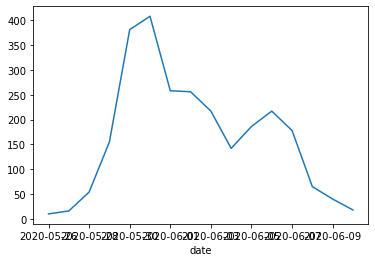

In [23]:
df_cd.groupby('date')['events'].sum().plot();

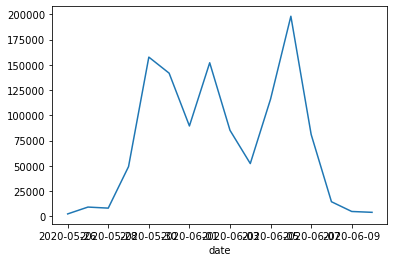

In [24]:
df_cd.groupby('date')['size_imp'].sum().plot();

In [25]:
df_cd['size_imp'].count()

2287

In [26]:
df_cd['size_imp'].sum()

1165066.0

In [27]:


df_cd['size'].describe()

count     1535.000000
mean       753.611726
std       3588.312076
min          1.000000
25%        100.000000
50%        200.000000
75%        472.500000
max      95500.000000
Name: size, dtype: float64

In [28]:
df_cd.groupby(["CCC", "Count Love", 'Elephrame'])['events'].count().reset_index()

,CCC,Count Love,Elephrame,events
0,0,0,1,255
1,0,1,0,875
2,0,1,1,112
3,1,0,0,524
4,1,0,1,51
5,1,1,0,325
6,1,1,1,145
